## IMPORT LIBRAIES

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
print('Seed: 42')




Seed: 42


In [2]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    # display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print('Shape df ', df.shape)
    print('Shape X', X.shape)
    print('Shape y: ', y.shape)
    return X, y

## READ DATASETS

In [3]:
dir = '../splits'
X_train, y_train = read_csv(f'{dir}/raw_train.csv')
X_test, y_test = read_csv(f'{dir}/raw_test.csv')
X_val, y_val = read_csv(f'{dir}/raw_val.csv')

X_val.head(3)

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 14)
Shape X (242, 13)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 14)
Shape X (31, 13)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 14)
Shape X (30, 13)
Shape y:  (30,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0


In [46]:
# FE Dataset
X_fe_train, y_fe_train = read_csv(f'{dir}/fe_train.csv')
X_fe_test, y_fe_test = read_csv(f'{dir}/fe_test.csv')
X_fe_val, y_fe_val = read_csv(f'{dir}/fe_val.csv')

X_fe_val.head(3)

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 14)
Shape X (242, 13)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 14)
Shape X (31, 13)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 14)
Shape X (30, 13)
Shape y:  (30,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_0.0
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,0.0


In [5]:
# Original + DT
X_dt_train, y_dt_train = read_csv(f'{dir}/dt_train.csv')
X_dt_test, y_dt_test = read_csv(f'{dir}/dt_test.csv')
X_dt_val, y_dt_val = read_csv(f'{dir}/dt_val.csv')

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 11)
Shape X (242, 10)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


In [6]:
# FEATURING + DECISTION TREE
X_fe_dt_train, y_fe_dt_train = read_csv(f'{dir}/fe_dt_train.csv')
X_fe_dt_test, y_fe_dt_test = read_csv(f'{dir}/fe_dt_test.csv')
X_fe_dt_val, y_fe_dt_val = read_csv(f'{dir}/fe_dt_val.csv')

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 11)
Shape X (242, 10)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


In [7]:
# FEATURING + DT + SMOTE
X_smote_train, y_smote_train = read_csv(f'{dir}/smote_fe_train.csv')
X_smote_test, y_smote_test = read_csv(f'{dir}/smote_fe_test.csv')
X_smote_val, y_smote_val = read_csv(f'{dir}/smote_fe_val.csv')

target
1    131
0    131
Name: count, dtype: int64

Shape df  (262, 11)
Shape X (262, 10)
Shape y:  (262,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


## MOCK HELPERS

In [8]:
# MOCK TUNING HELPERS (sklearn >= 1.7)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
)

# Optional libs
HAS_XGB = HAS_LGBM = HAS_CAT = True
try:
    from xgboost import XGBClassifier
except Exception as e:
    HAS_XGB = False; print("XGBoost not available:", e)
try:
    from lightgbm import LGBMClassifier
except Exception as e:
    HAS_LGBM = False; print("LightGBM not available:", e)
try:
    from catboost import CatBoostClassifier
    Path('../splits/cat_tmp').mkdir(parents=True, exist_ok=True)
except Exception as e:
    HAS_CAT = False; print("CatBoost not available:", e)

SEED = 42
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def make_out(name_key: str, est, best_params: dict, X, y, scoring='accuracy'):
    est.fit(X, y)
    try:
        cv_score = cross_val_score(est, X, y, cv=cv5, scoring=scoring, n_jobs=-1).mean()
    except Exception:
        pred = est.predict(X)
        cv_score = accuracy_score(y, pred)
    return {
        "name": name_key,
        "best_score": float(cv_score),
        "best_params": dict(best_params),
        "best_estimator": est,
    }

def define_mock_outs(X, y, prefix=""):
    # Compose variable name like out_{prefix}_ada or out_ada when prefix == ""
    def setvar(suffix, value):
        varname = f"out_{(prefix + '_') if prefix else ''}{suffix}"
        globals()[varname] = value
        print("Defined", varname)

    # AdaBoost (API mới: estimator=)
    ada_params = {"n_estimators": 200, "learning_rate": 0.03729717290662577, "dt_max_depth": 1}
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=SEED),
        n_estimators=ada_params["n_estimators"],
        learning_rate=ada_params["learning_rate"],
        random_state=SEED
    )
    setvar("ada", make_out("adb", ada, ada_params, X, y))

    # RandomForest
    rf_params = {"n_estimators": 900, "max_depth": 12, "min_samples_split": 7}
    rf = RandomForestClassifier(
        n_estimators=rf_params["n_estimators"],
        max_depth=rf_params["max_depth"],
        min_samples_split=rf_params["min_samples_split"],
        n_jobs=-1, random_state=SEED
    )
    setvar("rf", make_out("rf", rf, rf_params, X, y))

    # GradientBoosting
    gb_params = {"n_estimators": 200, "learning_rate": 0.041604611269339564, "max_depth": 2, "min_samples_leaf": 2}
    gb = GradientBoostingClassifier(
        n_estimators=gb_params["n_estimators"],
        learning_rate=gb_params["learning_rate"],
        max_depth=gb_params["max_depth"],
        min_samples_leaf=gb_params["min_samples_leaf"],
        random_state=SEED
    )
    setvar("gb", make_out("gb", gb, gb_params, X, y))

    # LightGBM
    if HAS_LGBM:
        lgbm_params = {
            "n_estimators": 700, "num_leaves": 127, "learning_rate": 0.024332353079705077,
            "min_child_samples": 38, "subsample": 0.7636828373411673,
            "colsample_bytree": 0.8062473945344163, "reg_alpha": 0.5410345586666022,
            "reg_lambda": 0.8011381093354967
        }
        lgbm = LGBMClassifier(
            n_estimators=lgbm_params["n_estimators"],
            num_leaves=lgbm_params["num_leaves"],
            learning_rate=lgbm_params["learning_rate"],
            min_child_samples=lgbm_params["min_child_samples"],
            subsample=lgbm_params["subsample"],
            colsample_bytree=lgbm_params["colsample_bytree"],
            reg_alpha=lgbm_params["reg_alpha"],
            reg_lambda=lgbm_params["reg_lambda"],
            n_jobs=-1, random_state=SEED, verbose=-1
        )
        setvar("lgbm", make_out("lgbm", lgbm, lgbm_params, X, y))
    else:
        setvar("lgbm", {"name":"lgbm","best_score":0.0,"best_params":{},"best_estimator":None})

    # XGBoost
    if HAS_XGB:
        xgb_params = {
            "n_estimators": 400, "max_depth": 4, "learning_rate": 0.0343796329533941,
            "subsample": 0.8, "colsample_bytree": 0.7980976532947479,
            "reg_lambda": 0.8, "reg_alpha": 0.5
        }
        xgb = XGBClassifier(
            n_estimators=xgb_params["n_estimators"],
            max_depth=xgb_params["max_depth"],
            learning_rate=xgb_params["learning_rate"],
            subsample=xgb_params["subsample"],
            colsample_bytree=xgb_params["colsample_bytree"],
            reg_lambda=xgb_params["reg_lambda"],
            reg_alpha=xgb_params["reg_alpha"],
            n_jobs=-1, random_state=SEED,
            eval_metric="logloss", tree_method="hist", use_label_encoder=False
        )
        setvar("xgb", make_out("xgb", xgb, xgb_params, X, y))
    else:
        setvar("xgb", {"name":"xgb","best_score":0.0,"best_params":{},"best_estimator":None})

    # CatBoost (train_dir để tránh lỗi tmp)
    if HAS_CAT:
        cat_params = {"n_estimators": 800, "depth": 6, "learning_rate": 0.05, "l2_leaf_reg": 3.0, "subsample": 0.8}
        cat = CatBoostClassifier(
            n_estimators=cat_params["n_estimators"],
            depth=cat_params["depth"],
            learning_rate=cat_params["learning_rate"],
            l2_leaf_reg=cat_params["l2_leaf_reg"],
            subsample=cat_params["subsample"],
            loss_function="Logloss", eval_metric="AUC",
            random_state=SEED, verbose=0, train_dir=str(Path("../splits/cat_tmp"))
        )
        setvar("cat", make_out("cat", cat, cat_params, X, y))
    else:
        setvar("cat", {"name":"cat","best_score":0.0,"best_params":{},"best_estimator":None})


## TỐI ƯU THAM SỐ DÙNG OPTUNA

In [9]:
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import clone

SEED     = 42
N_JOBS   = -1
SCORING  = "accuracy"  # đổi "f1" hoặc "roc_auc" nếu cần
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# ===== Suggest spaces cho 6 model =====
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier

def suggest_rf(trial):
    return RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 300, 900, step=300),
        max_depth=trial.suggest_categorical("max_depth", [None, 12, 20, 30]),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
        random_state=SEED, n_jobs=N_JOBS
    )

def suggest_adb(trial):

    return AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=SEED),
        n_estimators=trial.suggest_int("n_estimators", 200, 800, step=200),
        learning_rate=trial.suggest_float("learning_rate", 0.03, 0.3, log=True),
        random_state=SEED
    )

def suggest_gb(trial):
    return GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 200, 800, step=200),
        learning_rate=trial.suggest_float("learning_rate", 0.03, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 5),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 3),
        random_state=SEED
    )

def suggest_xgb(trial):
    return XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 300, 1500, step=100),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.5, 2.0),
        n_jobs=N_JOBS, random_state=SEED, eval_metric="logloss", tree_method="hist"
    )

def suggest_lgbm(trial):
    return LGBMClassifier(
        verbose=-1,
        n_estimators=trial.suggest_int("n_estimators", 300, 1500, step=100),
        num_leaves=trial.suggest_int("num_leaves", 31, 255, step=32),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        min_child_samples=trial.suggest_int("min_child_samples", 5, 40),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.5, 2.0),
        n_jobs=N_JOBS, random_state=SEED
    )

def suggest_cat(trial):
    return CatBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 300, 1500, step=200),
        depth=trial.suggest_int("depth", 4, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 6.0),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        random_state=SEED, verbose=False
    )

SUGGESTERS = {
    "rf":   suggest_rf,
    "adb":  suggest_adb,
    "gb":   suggest_gb,
    "xgb":  suggest_xgb,
    "lgbm": suggest_lgbm,
    "cat":  suggest_cat,
}



In [51]:
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping  # đã import ở trên trong notebook của bạn

SEED = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

from lightgbm import early_stopping  # bạn đã import ở cell trước
from xgboost.callback import EarlyStopping as XgbEarlyStopping

def _fit_with_es(model_key, est, X_tr, y_tr, X_va, y_va, stopping_rounds):
    if model_key == "lgbm":
        # LightGBM dùng callback early_stopping
        est.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="auc",
            callbacks=[early_stopping(stopping_rounds, verbose=False)],
        )
        return est

    elif model_key == "cat":
        # CatBoost vẫn nhận early_stopping_rounds + use_best_model
        est.set_params(loss_function="Logloss", eval_metric="AUC")
        est.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            use_best_model=True,
            early_stopping_rounds=stopping_rounds,
            verbose=False,
        )
        return est

    # Các model khác không hỗ trợ ES
    est.fit(X_tr, y_tr)
    return est

def optuna_tune_simple(model_key, X, y, n_trials=40, scoring="roc_auc",
                   with_early_stopping=True, es_min=50, es_max=200,
                   final_refit_with_es=True, final_val_frac=0.15):
    """
    Tuning với Optuna + Early Stopping theo fold (xgb/lgbm/cat).
    Với rf/adb/gb không hỗ trợ ES, vẫn chạy như thường.
    """
    suggest_fn = SUGGESTERS[model_key]

    def objective(trial):
        est = suggest_fn(trial)
        # Thử stopping_rounds khi model hỗ trợ
        stopping_rounds = None
        if with_early_stopping and model_key in ( "lgbm", "cat"):
            stopping_rounds = trial.suggest_int("stopping_rounds", es_min, es_max)

        fold_scores = []
        for tr_idx, va_idx in cv.split(X, y):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

            est_fold = clone(est)
            if stopping_rounds is not None:
                est_fold = _fit_with_es(model_key, est_fold, X_tr, y_tr, X_va, y_va, stopping_rounds)
            else:
                est_fold.fit(X_tr, y_tr)

            # Đo ROC AUC trên fold-val (ưu tiên predict_proba)
            if hasattr(est_fold, "predict_proba"):
                prob = est_fold.predict_proba(X_va)[:, 1]
                score = roc_auc_score(y_va, prob)
            elif hasattr(est_fold, "decision_function"):
                s = est_fold.decision_function(X_va)
                # Chuẩn hoá về [0,1] để tính AUC nếu cần
                s = (s - s.min()) / (s.max() - s.min() + 1e-12)
                score = roc_auc_score(y_va, s)
            else:
                # fallback (kém chính xác cho AUC)
                pred = est_fold.predict(X_va)
                score = roc_auc_score(y_va, pred)
            fold_scores.append(score)

        return float(np.mean(fold_scores))

    study = optuna.create_study(direction="maximize", study_name=f"{model_key}_es")
    study.optimize(objective, n_trials=n_trials)

    # Dựng best_estimator và fit cuối
    best_est = suggest_fn(study.best_trial)
    stopping_rounds = study.best_trial.params.get("stopping_rounds", None)

    if final_refit_with_es and (stopping_rounds is not None) and model_key in ("lgbm", "cat"):
        X_tr, X_va, y_tr, y_va = train_test_split(
            X, y, test_size=final_val_frac, stratify=y, random_state=SEED
        )
        best_est = _fit_with_es(model_key, best_est, X_tr, y_tr, X_va, y_va, stopping_rounds)
    else:
        best_est.fit(X, y)

    return {
        "name": model_key,
        "best_score": study.best_value,
        "best_params": study.best_trial.params,
        "best_estimator": best_est
    }


In [10]:
def calc_results(ranked, X_test, y_test, X_val, y_val):
    results = {}
    for r in ranked:
        results[r['name']] = {
            'val': accuracy_score(y_val, r['best_estimator'].predict(X_val)),
            'test': accuracy_score(y_test, r['best_estimator'].predict(X_test)),
        }
    # print(results)
    return results

In [11]:
def visualize(results, data_name=''):
    algos = list(results.keys())
    val_scores = [results[a]['val'] for a in algos]
    test_scores = [results[a]['test'] for a in algos]

    x = np.arange(len(algos))
    width = 0.38
    fig, ax = plt.subplots()
    b1 = ax.bar(x - width / 2, val_scores, width, label='Validation Accuracy')
    b2 = ax.bar(x + width / 2, test_scores, width, label='Test Accuracy')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Algorithms')
    ax.set_title(f'{data_name} Validation vs Test Scores by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(algos)
    ax.legend()

    def annotate(bars):
        for bar in bars:
            h = bar.get_height()
            ax.annotate('{:.2f}'.format(h), (bar.get_x() + bar.get_width()/ 2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom')
    annotate(b1)
    annotate(b2)
    plt.show()

## ORIGINAL DATASET

In [12]:
# MOCK for Original (raw) dataset — đặt ngay sau cell READ DATASETS raw
define_mock_outs(X_train, y_train, prefix="")
# Sinh ra: out_ada, out_rf, out_gb, out_lgbm, out_xgb, out_cat

Defined out_ada
Defined out_rf
Defined out_gb
Defined out_lgbm
Defined out_xgb
Defined out_cat


In [13]:
# === Gọi ví dụ:
out_lgbm = optuna_tune_simple("lgbm", X_train, y_train, n_trials=50, scoring="accuracy")
out_cat  = optuna_tune_simple("cat",  X_train, y_train)

[I 2025-10-02 22:23:07,349] A new study created in memory with name: lgbm_simple
[I 2025-10-02 22:23:08,359] Trial 0 finished with value: 0.7889455782312924 and parameters: {'n_estimators': 400, 'num_leaves': 255, 'learning_rate': 0.17094957841772193, 'min_child_samples': 12, 'subsample': 0.8257808208916684, 'colsample_bytree': 0.9247137095488004, 'reg_alpha': 0.3400000510929405, 'reg_lambda': 1.5406083392809689}. Best is trial 0 with value: 0.7889455782312924.
[I 2025-10-02 22:23:11,222] Trial 1 finished with value: 0.8096088435374149 and parameters: {'n_estimators': 1000, 'num_leaves': 191, 'learning_rate': 0.02014531692113209, 'min_child_samples': 23, 'subsample': 0.9462547194806241, 'colsample_bytree': 0.9473570564737204, 'reg_alpha': 0.6021139757200088, 'reg_lambda': 1.298717545280411}. Best is trial 1 with value: 0.8096088435374149.
[I 2025-10-02 22:23:14,060] Trial 2 finished with value: 0.8137755102040817 and parameters: {'n_estimators': 300, 'num_leaves': 255, 'learning_rate':

In [14]:
out_xgb  = optuna_tune_simple("xgb",  X_train, y_train)

[I 2025-10-02 22:30:33,939] A new study created in memory with name: xgb_simple
[I 2025-10-02 22:30:35,484] Trial 0 finished with value: 0.7889455782312925 and parameters: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.05355388821058314, 'subsample': 0.9742068014267249, 'colsample_bytree': 0.9599127049378849, 'reg_alpha': 0.597990497384738, 'reg_lambda': 1.7246130119407985}. Best is trial 0 with value: 0.7889455782312925.
[I 2025-10-02 22:30:38,101] Trial 1 finished with value: 0.7849489795918367 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.10467977702180482, 'subsample': 0.971059810318118, 'colsample_bytree': 0.8224982682770924, 'reg_alpha': 0.08715954252240266, 'reg_lambda': 1.870462355374999}. Best is trial 0 with value: 0.7889455782312925.
[I 2025-10-02 22:30:39,663] Trial 2 finished with value: 0.7846938775510204 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.062064691637893556, 'subsample': 0.9996538247614752, 'colsa

In [15]:
out_rf = optuna_tune_simple("rf", X_train, y_train)
out_gb = optuna_tune_simple('gb', X_train, y_train)

[I 2025-10-02 22:31:02,297] A new study created in memory with name: rf_simple
[I 2025-10-02 22:31:08,015] Trial 0 finished with value: 0.8055272108843538 and parameters: {'n_estimators': 300, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8055272108843538.
[I 2025-10-02 22:31:12,389] Trial 1 finished with value: 0.7973639455782313 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8055272108843538.
[I 2025-10-02 22:31:18,657] Trial 2 finished with value: 0.7973639455782313 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8055272108843538.
[I 2025-10-02 22:31:26,268] Trial 3 finished with value: 0.8137755102040817 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8137755102040817.
[I 2025

In [16]:
out_ada = optuna_tune_simple('adb', X_train, y_train, n_trials=50)

[I 2025-10-02 22:33:04,147] A new study created in memory with name: adb_simple
[I 2025-10-02 22:33:04,864] Trial 0 finished with value: 0.8305272108843538 and parameters: {'n_estimators': 200, 'learning_rate': 0.11602457674922251}. Best is trial 0 with value: 0.8305272108843538.
[I 2025-10-02 22:33:06,320] Trial 1 finished with value: 0.8179421768707483 and parameters: {'n_estimators': 600, 'learning_rate': 0.20506907834055518}. Best is trial 0 with value: 0.8305272108843538.
[I 2025-10-02 22:33:06,858] Trial 2 finished with value: 0.8263605442176871 and parameters: {'n_estimators': 200, 'learning_rate': 0.1461644290441694}. Best is trial 0 with value: 0.8305272108843538.
[I 2025-10-02 22:33:07,327] Trial 3 finished with value: 0.8305272108843538 and parameters: {'n_estimators': 200, 'learning_rate': 0.11515843555726013}. Best is trial 0 with value: 0.8305272108843538.
[I 2025-10-02 22:33:09,166] Trial 4 finished with value: 0.8096938775510203 and parameters: {'n_estimators': 800, 'le

In [17]:
ranked = sorted([out_ada, out_rf, out_gb, out_lgbm, out_xgb, out_cat], key=lambda x: x["best_score"], reverse=True)

In [18]:
raw_results = calc_results(ranked, X_test, y_test, X_val, y_val)

In [19]:
raw_results

{'adb': {'val': 0.9333333333333333, 'test': 0.8709677419354839},
 'lgbm': {'val': 0.8666666666666667, 'test': 0.8709677419354839},
 'cat': {'val': 0.9, 'test': 0.8064516129032258},
 'rf': {'val': 0.9333333333333333, 'test': 0.8709677419354839},
 'xgb': {'val': 0.9333333333333333, 'test': 0.8387096774193549},
 'gb': {'val': 0.9, 'test': 0.8064516129032258}}

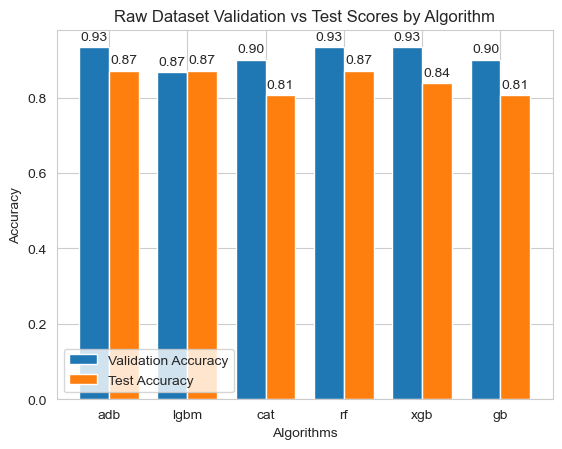

In [20]:
visualize(raw_results, 'Raw Dataset')

In [21]:
for r in ranked:
    print(r['best_estimator'])

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.06484894922868152, n_estimators=200,
                   random_state=42)
LGBMClassifier(colsample_bytree=0.7243364749406372,
               learning_rate=0.09830149739307255, min_child_samples=40,
               n_estimators=300, n_jobs=-1, num_leaves=95, random_state=42,
               reg_alpha=0.5097827013551092, reg_lambda=0.9692849916402695,
               subsample=0.9016369252657277, verbose=-1)
RandomForestClassifier(max_depth=30, n_estimators=300, n_jobs=-1,
                       random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7700309076915354, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature

## DT DATASET

In [22]:
# MOCK for DT dataset — sau cell đọc X_dt_*
define_mock_outs(X_dt_train, y_dt_train, prefix="dt")
# out_dt_ada, out_dt_rf, out_dt_gb, out_dt_lgbm, out_dt_xgb, out_dt_cat

Defined out_dt_ada
Defined out_dt_rf
Defined out_dt_gb
Defined out_dt_lgbm
Defined out_dt_xgb
Defined out_dt_cat


In [ ]:
out_dt_lgbm = optuna_tune_simple("lgbm", X_dt_train, y_dt_train, n_trials=40, scoring="accuracy")
out_dt_xgb  = optuna_tune_simple("xgb",  X_dt_train, y_dt_train)
out_dt_cat  = optuna_tune_simple("cat",  X_dt_train, y_dt_train)
out_dt_rf = optuna_tune_simple("rf", X_dt_train, y_dt_train)
out_dt_gb = optuna_tune_simple('gb', X_dt_train, y_dt_train)
out_dt_ada = optuna_tune_simple('adb', X_dt_train, y_dt_train)

In [52]:
dt_ranked = sorted([out_dt_ada, out_dt_rf, out_dt_gb, out_dt_lgbm, out_dt_xgb, out_dt_cat], key=lambda x: x["best_score"], reverse=True)

In [53]:
dt_results = calc_results(dt_ranked, X_dt_test, y_dt_test, X_dt_val, y_dt_val)

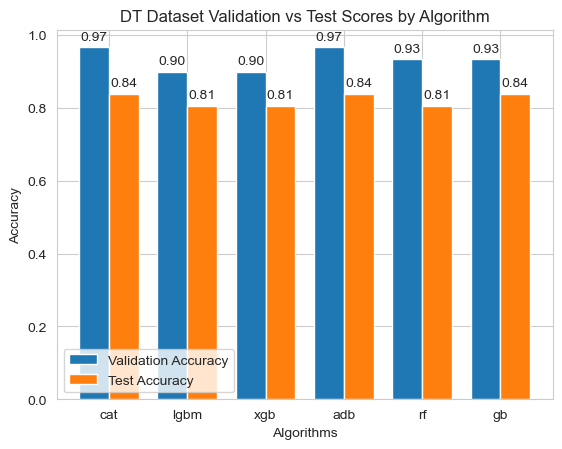

In [54]:
visualize(dt_results, 'DT Dataset')

## FE DATASET

In [32]:
# MOCK for FE dataset — sau cell đọc X_fe_*
define_mock_outs(X_fe_train, y_fe_train, prefix="fe")


Defined out_fe_ada
Defined out_fe_rf
Defined out_fe_gb
Defined out_fe_lgbm
Defined out_fe_xgb
Defined out_fe_cat


In [ ]:
out_fe_lgbm = optuna_tune_simple("lgbm", X_fe_train, y_fe_train, n_trials=40, scoring="accuracy")
out_fe_cat  = optuna_tune_simple("cat",  X_fe_train, y_fe_train)
out_fe_xgb  = optuna_tune_simple("xgb",  X_fe_train, y_fe_train)
out_fe_rf   = optuna_tune_simple("rf",   X_fe_train, y_fe_train)
out_fe_gb   = optuna_tune_simple('gb',   X_fe_train, y_fe_train)
out_fe_ada  = optuna_tune_simple('adb',  X_fe_train, y_fe_train)

In [33]:
fe_ranked = sorted([out_fe_ada, out_fe_rf, out_fe_gb, out_fe_lgbm, out_fe_xgb, out_fe_cat],
                   key=lambda x: x["best_score"], reverse=True)


In [34]:
fe_results = calc_results(fe_ranked, X_fe_test, y_fe_test, X_fe_val, y_fe_val)

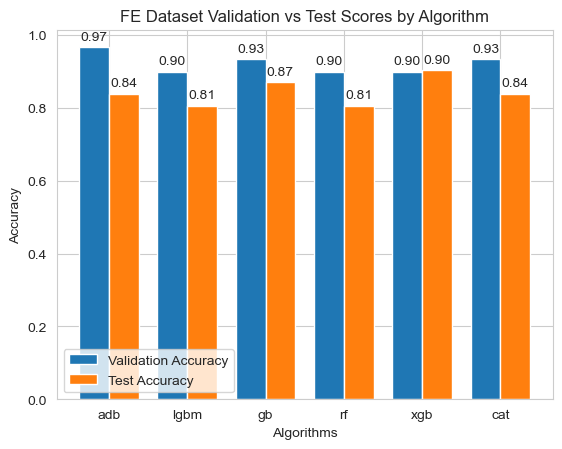

In [35]:
visualize(fe_results, 'FE Dataset')

## FE + DT DATASET

In [55]:
# MOCK for FE + DT dataset — sau cell đọc X_fe_dt_*
define_mock_outs(X_fe_dt_train, y_fe_dt_train, prefix="fe_dt")


Defined out_fe_dt_ada
Defined out_fe_dt_rf
Defined out_fe_dt_gb
Defined out_fe_dt_lgbm
Defined out_fe_dt_xgb
Defined out_fe_dt_cat


In [ ]:
out_fe_dt_lgbm = optuna_tune_simple("lgbm", X_fe_dt_train, y_fe_dt_train, n_trials=40, scoring="accuracy")
out_fe_dt_cat  = optuna_tune_simple("cat",  X_fe_dt_train, y_fe_dt_train)
out_fe_dt_xgb  = optuna_tune_simple("xgb",  X_fe_dt_train, y_fe_dt_train)
out_fe_dt_rf   = optuna_tune_simple("rf",   X_fe_dt_train, y_fe_dt_train)
out_fe_dt_gb   = optuna_tune_simple('gb',   X_fe_dt_train, y_fe_dt_train)
out_fe_dt_ada  = optuna_tune_simple('adb',  X_fe_dt_train, y_fe_dt_train)

In [56]:
fe_dt_ranked = sorted([out_fe_dt_ada, out_fe_dt_rf, out_fe_dt_gb, out_fe_dt_lgbm, out_fe_dt_xgb, out_fe_dt_cat],
                      key=lambda x: x["best_score"], reverse=True)


In [57]:
fe_dt_results = calc_results(fe_dt_ranked, X_fe_dt_test, y_fe_dt_test, X_fe_dt_val, y_fe_dt_val)

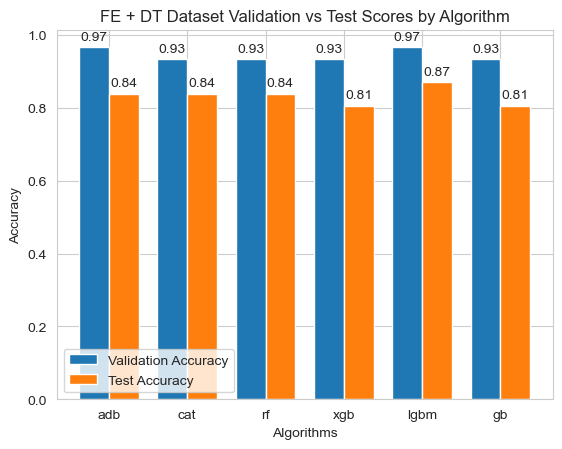

In [58]:
visualize(fe_dt_results, 'FE + DT Dataset')

## SMOTE DATASET

In [47]:
# MOCK for FE + SMOTE (train) — sau cell đọc X_smote_*
define_mock_outs(X_smote_train, y_smote_train, prefix="fe_sm")


Defined out_fe_sm_ada
Defined out_fe_sm_rf
Defined out_fe_sm_gb
Defined out_fe_sm_lgbm
Defined out_fe_sm_xgb
Defined out_fe_sm_cat


In [ ]:
out_fe_sm_lgbm = optuna_tune_simple("lgbm", X_smote_train, y_smote_train, n_trials=40, scoring="accuracy")
out_fe_sm_cat  = optuna_tune_simple("cat",  X_smote_train, y_smote_train)
out_fe_sm_xgb  = optuna_tune_simple("xgb",  X_smote_train, y_smote_train)
out_fe_sm_rf   = optuna_tune_simple("rf",   X_smote_train, y_smote_train)
out_fe_sm_gb   = optuna_tune_simple('gb',   X_smote_train, y_smote_train)
out_fe_sm_ada  = optuna_tune_simple('adb',  X_smote_train, y_smote_train)


In [59]:
fe_sm_ranked = sorted([out_fe_sm_ada, out_fe_sm_rf, out_fe_sm_gb, out_fe_sm_lgbm, out_fe_sm_xgb, out_fe_sm_cat], key=lambda x: x['best_score'], reverse=True)


In [60]:
fe_sm_results = calc_results(fe_sm_ranked, X_smote_test, y_smote_test, X_smote_val, y_smote_val)

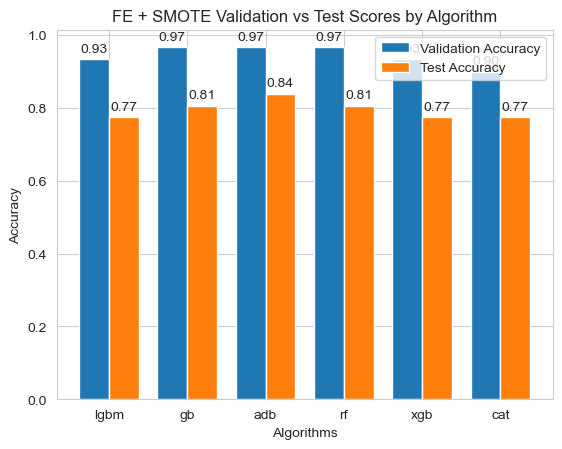

In [63]:
visualize(fe_sm_results, 'FE + SMOTE')


## RESULT REPORT

In [64]:
# Aggregate best estimators across datasets and save to CSV
from pathlib import Path
import json
import pandas as pd

# Map dataset -> variable prefix used in your notebook variables
dataset_prefixes = {
    'raw':   '',        # e.g., out_ada, out_rf, ...
    'dt':    'dt',      # e.g., out_dt_ada, out_dt_rf, ...
    'fe':    'fe',      # e.g., out_fe_ada, ...
    'fe_dt': 'fe_dt',   # e.g., out_fe_dt_ada, ...
    'fe_sm': 'fe_sm',   # e.g., out_fe_sm_ada, ...
}

# 6 algorithms (matching keys used in SUGGESTERS)
alg_order = ['adb', 'rf', 'gb', 'lgbm', 'xgb', 'cat']

# Map algorithm key -> suffix used in your variable names
suffix_map = {'adb': 'ada', 'rf': 'rf', 'gb': 'gb', 'lgbm': 'lgbm', 'xgb': 'xgb', 'cat': 'cat'}

def get_out(prefix: str, alg: str):
    # Compose variable name e.g., out_fe_dt_ada or out_rf
    varname = f"out_{(prefix + '_') if prefix else ''}{suffix_map[alg]}"
    return globals().get(varname, None)

rows = []
for ds, prefix in dataset_prefixes.items():
    for alg in alg_order:
        out = get_out(prefix, alg)
        if out is None:
            continue
        est = out.get('best_estimator')
        params = out.get('best_params', {})
        score = out.get('best_score', None)
        score_fmt = f"{score:.4f}" if isinstance(score, (int, float)) else str(score)
        est_class = type(est).__name__ if est is not None else ''
        est_repr = (repr(est) if est is not None else '').replace('\n', ' ').replace('\r', ' ')
        print(f"[{ds}] {alg}: score={score_fmt}  estimator={est_class}")

        rows.append({
            'dataset': ds,
            'algorithm': alg,
            'best_score': score,
            'best_params_json': json.dumps(params),
            'estimator_class': est_class,
            'estimator_repr': est_repr
        })

best_df = pd.DataFrame(rows).sort_values(['dataset','algorithm']).reset_index(drop=True)
out_path = Path('../splits') / 'best_estimators_summary.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
best_df.to_csv(out_path, index=False)
print("Saved:", out_path)
best_df.head()


[raw] adb: score=0.8387  estimator=AdaBoostClassifier
[raw] rf: score=0.8179  estimator=RandomForestClassifier
[raw] gb: score=0.7889  estimator=GradientBoostingClassifier
[raw] lgbm: score=0.8346  estimator=LGBMClassifier
[raw] xgb: score=0.8139  estimator=XGBClassifier
[raw] cat: score=0.8180  estimator=CatBoostClassifier
[dt] adb: score=0.8389  estimator=AdaBoostClassifier
[dt] rf: score=0.8222  estimator=RandomForestClassifier
[dt] gb: score=0.8057  estimator=GradientBoostingClassifier
[dt] lgbm: score=0.9124  estimator=LGBMClassifier
[dt] xgb: score=0.8801  estimator=XGBClassifier
[dt] cat: score=0.9212  estimator=CatBoostClassifier
[fe] adb: score=0.8305  estimator=AdaBoostClassifier
[fe] rf: score=0.7974  estimator=RandomForestClassifier
[fe] gb: score=0.8056  estimator=GradientBoostingClassifier
[fe] lgbm: score=0.8264  estimator=LGBMClassifier
[fe] xgb: score=0.7890  estimator=XGBClassifier
[fe] cat: score=0.7770  estimator=CatBoostClassifier
[fe_dt] adb: score=0.8182  estimat

,dataset,algorithm,best_score,best_params_json,estimator_class,estimator_repr
0,dt,adb,0.838861,"{""n_estimators"": 200, ""learning_rate"": 0.03729...",AdaBoostClassifier,AdaBoostClassifier(estimator=DecisionTreeClass...
1,dt,cat,0.921196,"{""n_estimators"": 400, ""depth"": 4, ""learning_ra...",CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...
2,dt,gb,0.805697,"{""n_estimators"": 200, ""learning_rate"": 0.04160...",GradientBoostingClassifier,GradientBoostingClassifier(learning_rate=0.041...
3,dt,lgbm,0.912375,"{""n_estimators"": 400, ""num_leaves"": 127, ""lear...",LGBMClassifier,LGBMClassifier(colsample_bytree=0.822047978444...
4,dt,rf,0.822194,"{""n_estimators"": 900, ""max_depth"": 12, ""min_sa...",RandomForestClassifier,"RandomForestClassifier(max_depth=12, min_sampl..."


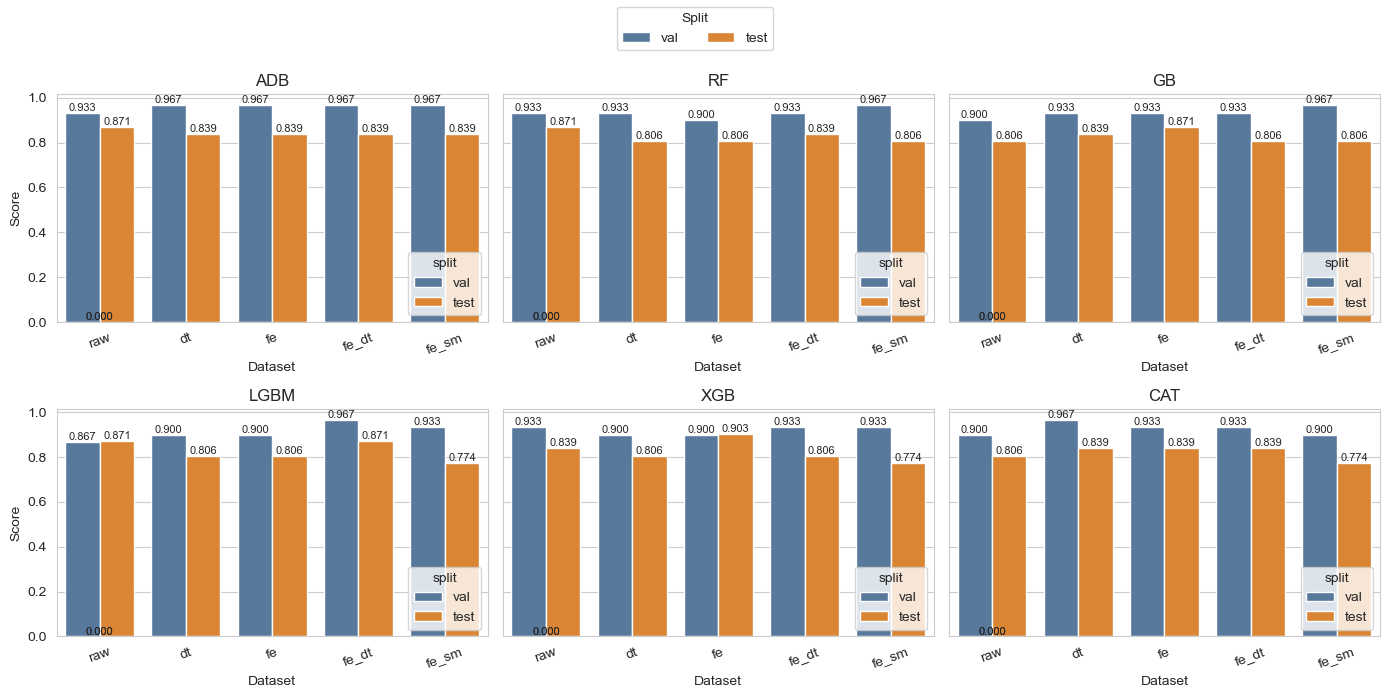

In [65]:
# Plot 6 charts: one per algorithm, showing val/test across datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These should be produced earlier via calc_results(...):
# raw_results, dt_results, fe_results, fe_dt_results, fe_sm_results
results_vars = {
    'raw':   'raw_results',
    'dt':    'dt_results',
    'fe':    'fe_results',
    'fe_dt': 'fe_dt_results',
    'fe_sm': 'fe_sm_results',
}

records = []
for ds, varname in results_vars.items():
    res = globals().get(varname, None)
    if res is None:
        continue
    # res expected format: { 'adb': {'val': score, 'test': score}, ... }
    for alg, metrics in res.items():
        if not isinstance(metrics, dict):
            continue
        for split in ['val', 'test']:
            val = metrics.get(split, None)
            if val is None:
                continue
            records.append({'dataset': ds, 'algorithm': alg, 'split': split, 'score': float(val)})

plot_df = pd.DataFrame(records)
alg_names = ['adb', 'rf', 'gb', 'lgbm', 'xgb', 'cat']

fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharey=True)
axes = axes.ravel()

for i, alg in enumerate(alg_names):
    ax = axes[i]
    sub = plot_df[plot_df['algorithm'] == alg]
    if sub.empty:
        ax.set_title(f"{alg.upper()} — no data")
        ax.axis('off')
        continue

    sns.barplot(data=sub, x='dataset', y='score', hue='split', ax=ax, palette=['#4c78a8', '#f58518'])
    ax.set_title(alg.upper())
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

    # annotate bars
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(f"{h:.3f}", (p.get_x() + p.get_width()/2, h), ha='center', va='bottom', fontsize=8)

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Split')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


## GIỚI THIỆU: DÙNG LAZYPREDICT ĐỂ XEM HIỆU QUẢ CỦA NHỮNG MÔ HÌNH KHÁC

In [68]:
from lazypredict.Supervised import  LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, _ = clf.fit(X_train, X_test, y_train, y_test)
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
PassiveAggressiveClassifier        0.90               0.91     0.91      0.90   
BernoulliNB                        0.90               0.91     0.91      0.90   
RandomForestClassifier             0.90               0.91     0.91      0.90   
KNeighborsClassifier               0.87               0.88     0.88      0.87   
AdaBoostClassifier                 0.87               0.88     0.88      0.87   
NearestCentroid                    0.87               0.88     0.88      0.87   
GaussianNB                         0.84               0.85     0.85      0.84   
LGBMClassifier                     0.84               0.84     0.84      0.84   
LabelPropagation                   0.81               0.82     0.82      0.80   
LabelSpreading                     0.81               0.82     0.82      0.80   
ExtraTreesClassifier        

**Có thể dùng LazyPredict để chọn ra các mô hình cơ sở tốt nhất, sau đó tối ưu theo số để chọn kết quả cuối**